In [17]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib.ticker import AutoMinorLocator


d:\github\ripple_heterogeneity


In [3]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def get_ripple_fr(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

basepath = r'Z:\Data\Kenji\km01.012_020'

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

restrict_idx = (
                    (cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False) 
                    )

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

# behavioral epochs
epoch_df = loading.load_epoch(basepath)
# some epochs will have repeating back to back sessions that are actually the same session
epoch_df = functions.compress_repeated_epochs(epoch_df)

behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                epoch_df.stopTime]).T])

# unit_mat = get_ripple_fr(st_unit[ripple_epochs],ripple_epochs)
unit_mat = get_participation(st_unit[ripple_epochs],ripple_epochs)

unit_mat = nel.AnalogSignalArray(data=unit_mat,timestamps=ripple_epochs.starts)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:236: UserWarning: fs was not specified, so we try to estimate it from the data...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.7718431614696357 Hz
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support

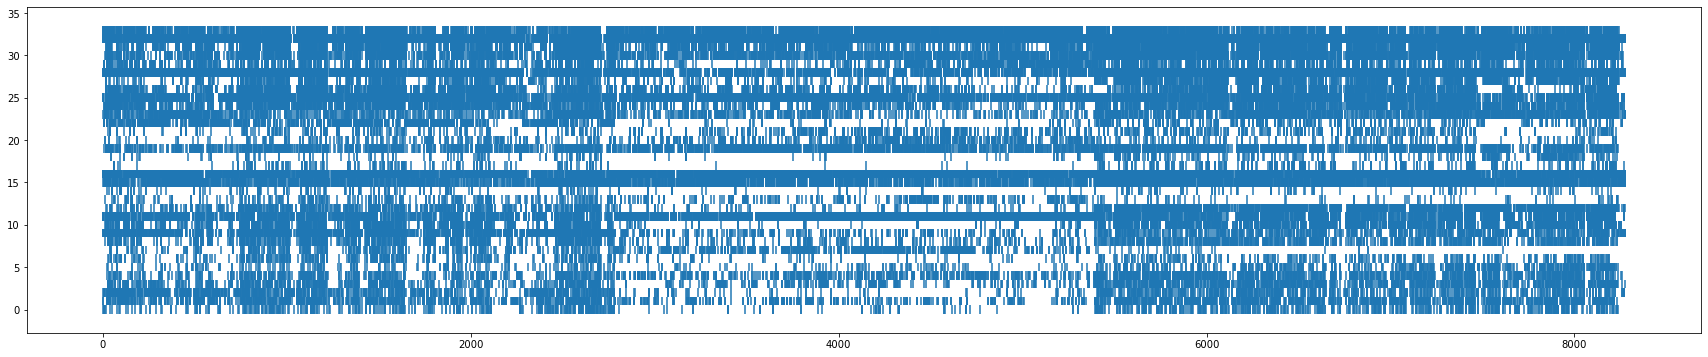

In [4]:
plt.figure(figsize=(30,6))
plt.eventplot(st_unit.data)
plt.show()

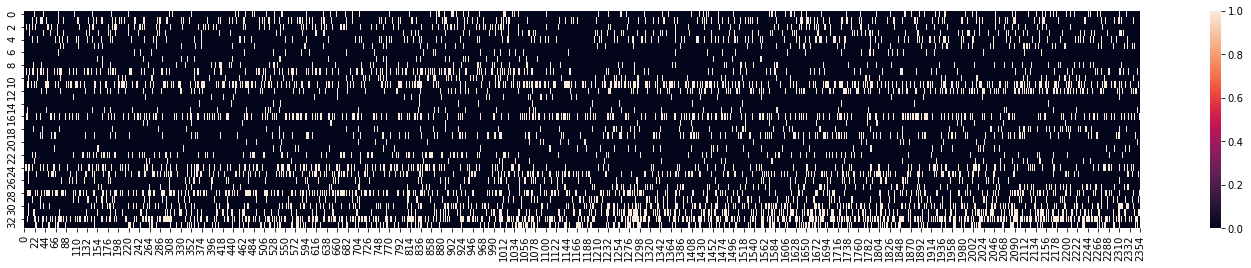

<AxesSubplot:>

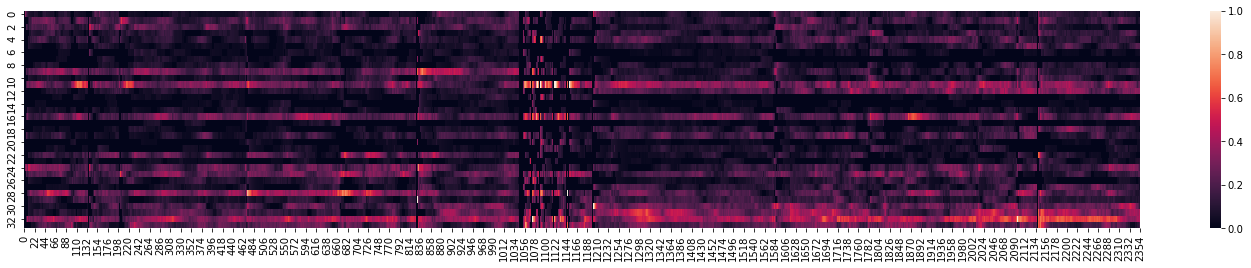

In [5]:
def smooth_unit_mat_moving_mean(unit_mat,window=60, min_periods=3):
    """
    smooth with irregular time in mind to minimize bias of far away events
    Input:  unit_mat: AnalogSignalArray object
            window: smoothing window in seconds
            min_periods: minimum data points for window, output values will drop to 0 if not met

    Output: unit_mat_sm: AnalogSignalArray object after smooth
    
    """
    # make copy 
    unit_mat_sm = unit_mat.copy()
    # pull out and format ts
    ts = [pd.Timestamp(val,unit='s') for val in unit_mat.abscissa_vals]
    # make data frame with ts as index
    df = pd.DataFrame(unit_mat.data.T,index=ts,columns=np.arange(unit_mat.data.shape[0]))
    # smooth with moving mean
    smoothed = df.rolling(str(window)+'s', min_periods=min_periods).mean().fillna(0)
    # add to object
    unit_mat_sm.data = smoothed.values.T

    return unit_mat_sm

unit_mat_sm = smooth_unit_mat_moving_mean(unit_mat)

plt.figure(figsize=(25,4))
sns.heatmap(unit_mat.data)
plt.show()

plt.figure(figsize=(25,4))
sns.heatmap(unit_mat_sm.data)

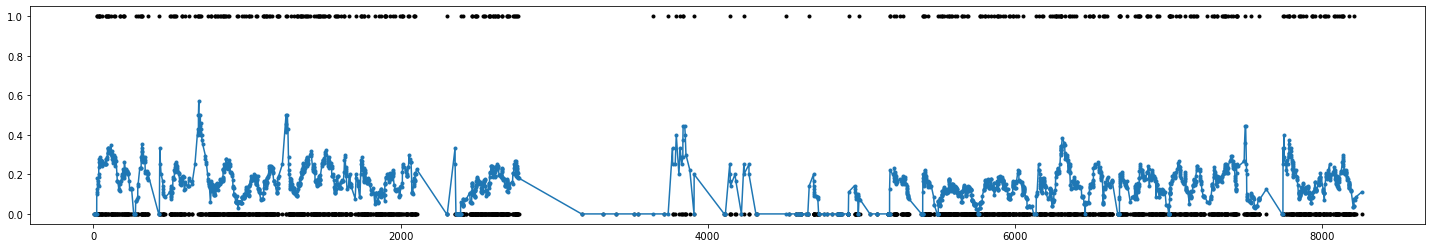

In [6]:
plt.figure(figsize=(25,4))
plt.plot(unit_mat.abscissa_vals, unit_mat.data[1],'.k',label='raw')
plt.plot(unit_mat_sm.abscissa_vals,unit_mat_sm.data[1],label='rolling',marker='.')

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


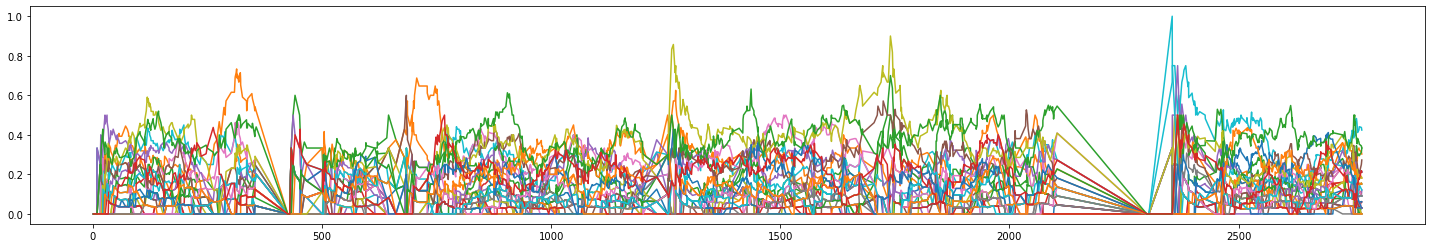

In [7]:
plt.figure(figsize=(25,4))

plt.plot(unit_mat_sm[behavioral_epochs[0]].abscissa_vals,unit_mat_sm[behavioral_epochs[0]].data.T)
plt.show()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


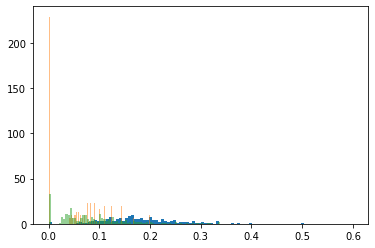

In [8]:
plt.hist(unit_mat_sm[behavioral_epochs[0]].data[2],100,density=True)
plt.hist(unit_mat_sm[behavioral_epochs[1]].data[2],100,alpha=.5,density=True)
plt.hist(unit_mat_sm[behavioral_epochs[2]].data[2],100,alpha=.5,density=True)
# plt.xscale('log')
plt.show()


In [50]:
y = unit_mat_sm.data[3]

epochs = []
for i in range(behavioral_epochs.n_intervals):
    unit_mat_sm[behavioral_epochs[i]]
    epochs.append(np.zeros([1,unit_mat_sm[behavioral_epochs[i]].data.shape[1]])+i)
epochs = np.hstack(epochs).T

df = pd.DataFrame()
df['constant'] = np.ones_like(epochs.T)[0]

df['ts'] = unit_mat_sm.abscissa_vals
df['ep'] = epochs
df['y'] = y

df

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


,constant,ts,ep,y
0,1.0,1.4976,0.0,0.000000
1,1.0,8.4688,0.0,0.000000
2,1.0,8.9872,0.0,0.000000
3,1.0,16.1808,0.0,0.000000
4,1.0,17.1744,0.0,0.000000
...,...,...,...,...
2350,1.0,8209.1784,2.0,0.076923
2351,1.0,8211.0064,2.0,0.074074
2352,1.0,8211.9024,2.0,0.071429
2353,1.0,8222.5480,2.0,0.043478


In [51]:
df = pd.concat([df,pd.get_dummies(df.ep,drop_first=True)],axis=1)


In [58]:
df['ep1'] = df[1.0]
df['ep2'] = df[2.0]
df.drop([1.0, 2.0], axis=1)

,constant,ts,ep,y,ep1,ep2
0,1.0,1.4976,0.0,0.000000,0,0
1,1.0,8.4688,0.0,0.000000,0,0
2,1.0,8.9872,0.0,0.000000,0,0
3,1.0,16.1808,0.0,0.000000,0,0
4,1.0,17.1744,0.0,0.000000,0,0
...,...,...,...,...,...,...
2350,1.0,8209.1784,2.0,0.076923,0,1
2351,1.0,8211.0064,2.0,0.074074,0,1
2352,1.0,8211.9024,2.0,0.071429,0,1
2353,1.0,8222.5480,2.0,0.043478,0,1


In [55]:
from sklearn.linear_model import LinearRegression

X = df[['constant','ts','ep1','ep2']].values
reg = LinearRegression().fit(X, y)

X = df[['constant','ts']].values
reg2 = LinearRegression().fit(X, y)

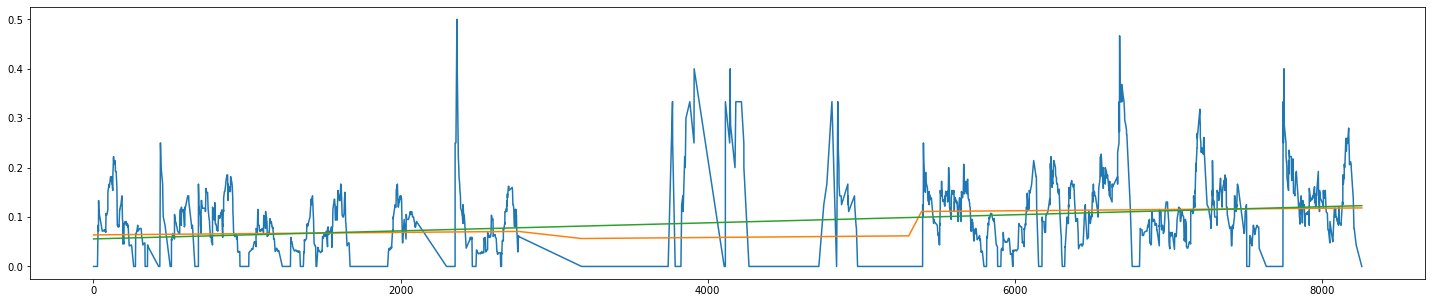

In [56]:
plt.figure(figsize=(25,5))
plt.plot(df['ts'],y)
plt.plot(df['ts'],reg.predict(df[['constant','ts','ep1','ep2']].values))
plt.plot(df['ts'],reg2.predict(df[['constant','ts']].values))


In [14]:
# import statsmodels.api as sm
# X = sm.add_constant(X)


In [57]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


m01 = ols('y ~ constant + ts', data=df).fit()
m02 = ols('y ~ constant + ts + ep1 + ep2', data=df).fit()
anovaResults = anova_lm(m01, m02)

print(anovaResults)


   df_resid        ssr  df_diff  ss_diff          F        Pr(>F)
0    2353.0  11.125391      0.0      NaN        NaN           NaN
1    2351.0  10.881762      2.0  0.24363  26.318062  4.969153e-12


In [59]:
print(m02.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     98.57
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.27e-60
Time:                        16:07:42   Log-Likelihood:                 2990.1
No. Observations:                2355   AIC:                            -5972.
Df Residuals:                    2351   BIC:                            -5949.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0319      0.002     19.918      0.0